# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install vit_pytorch linformer timm

     |████████████████████████████████| 68 kB 4.5 MB/s 
     |████████████████████████████████| 431 kB 17.8 MB/s 


## Import Libraries

In [ ]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT

In [ ]:
print(f"Torch: {torch.__version__}")

Torch: 1.11.0+cu113


In [ ]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
device = 'cuda'

## Load Data

In [ ]:
os.makedirs('data', exist_ok=True)

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Data/ViT/train'
test_dir = '/content/drive/MyDrive/Colab Data/ViT/test'

In [ ]:
with zipfile.ZipFile(train_dir + '/train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile(test_dir + '/test.zip') as test_zip:
    test_zip.extractall('data')

In [ ]:
train_list = glob.glob(os.path.join('/content/data/train','*.jpg'))
test_list = glob.glob(os.path.join('/content/data/test', '*.jpg'))

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [ ]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

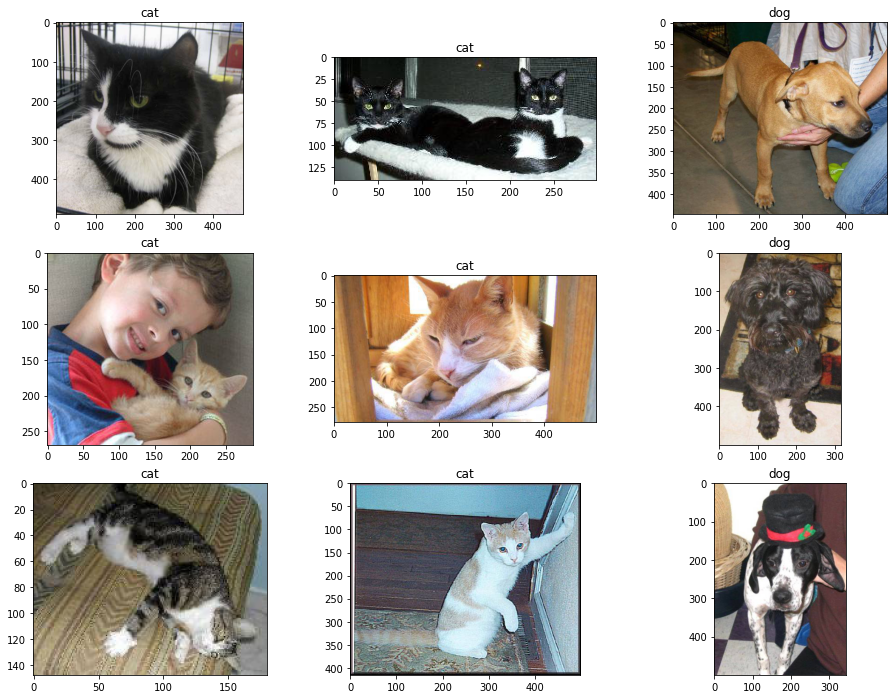

In [ ]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [ ]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augumentation

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [ ]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [ ]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))

20000 313


In [ ]:
print(len(valid_data), len(valid_loader))

5000 79


## Effecient Attention

### Linformer

In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

### Visual Transformer

In [ ]:
# 独自にモデルを構築する場合は､以下を実行する｡事前学習済モデルを使う場合はコメントアウトする｡
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [ ]:
# 事前学習済モデルを使う場合は､以下を実行｡モデルは使用するものに合わせて適宜変更する｡
# model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2).to(device)

### Training

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
# 学習過程可視化の準備
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    
    # 学習過程を可視化するための準備
    train_acc_list.append(epoch_accuracy)
    val_acc_list.append(epoch_val_accuracy)
    train_loss_list.append(epoch_loss)
    val_loss_list.append(epoch_val_loss)

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.6938 - acc: 0.5114 - val_loss : 0.6928 - val_acc: 0.5087



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6908 - acc: 0.5287 - val_loss : 0.6838 - val_acc: 0.5623



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6816 - acc: 0.5565 - val_loss : 0.6723 - val_acc: 0.5965



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6791 - acc: 0.5688 - val_loss : 0.6676 - val_acc: 0.6064



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6744 - acc: 0.5759 - val_loss : 0.6659 - val_acc: 0.5864



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6685 - acc: 0.5817 - val_loss : 0.6525 - val_acc: 0.6058



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6613 - acc: 0.5931 - val_loss : 0.6336 - val_acc: 0.6470



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6502 - acc: 0.6077 - val_loss : 0.6238 - val_acc: 0.6568



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6476 - acc: 0.6113 - val_loss : 0.6163 - val_acc: 0.6580



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6406 - acc: 0.6202 - val_loss : 0.6089 - val_acc: 0.6687



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6375 - acc: 0.6279 - val_loss : 0.6086 - val_acc: 0.6675



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6302 - acc: 0.6382 - val_loss : 0.6120 - val_acc: 0.6618



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6253 - acc: 0.6434 - val_loss : 0.5929 - val_acc: 0.6770



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6194 - acc: 0.6507 - val_loss : 0.5845 - val_acc: 0.6901



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6138 - acc: 0.6557 - val_loss : 0.5814 - val_acc: 0.6942



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.6098 - acc: 0.6582 - val_loss : 0.5673 - val_acc: 0.7059



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.6070 - acc: 0.6607 - val_loss : 0.5658 - val_acc: 0.7047



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.6009 - acc: 0.6676 - val_loss : 0.5583 - val_acc: 0.7057



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5977 - acc: 0.6738 - val_loss : 0.5710 - val_acc: 0.7100



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5992 - acc: 0.6699 - val_loss : 0.5614 - val_acc: 0.7011



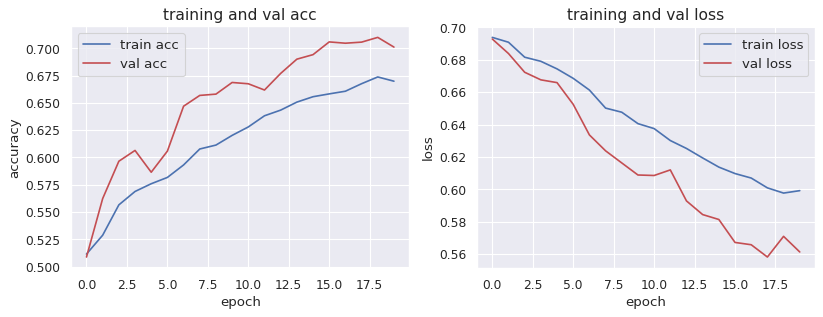

In [ ]:
#出力したテンソルのデバイスをCPUへ切り替える
device2 = torch.device('cpu')

train_acc = []
train_loss = []
val_acc = []
val_loss = []

for i in range(epochs):
    train_acc2 = train_acc_list[i].to(device2)
    train_acc3 = train_acc2.clone().numpy()
    train_acc.append(train_acc3)
    
    train_loss2 = train_loss_list[i].to(device2)
    train_loss3 = train_loss2.clone().detach().numpy()
    train_loss.append(train_loss3)
    
    val_acc2 = val_acc_list[i].to(device2)
    val_acc3 = val_acc2.clone().numpy()
    val_acc.append(val_acc3)
    
    val_loss2 = val_loss_list[i].to(device2)
    val_loss3 = val_loss2.clone().numpy()
    val_loss.append(val_loss3)

#取得したデータをグラフ化する
sns.set()
num_epochs = epochs

fig = plt.subplots(figsize=(12, 4), dpi=80)

ax1 = plt.subplot(1,2,1)
ax1.plot(range(num_epochs), train_acc, c='b', label='train acc')
ax1.plot(range(num_epochs), val_acc, c='r', label='val acc')
ax1.set_xlabel('epoch', fontsize='12')
ax1.set_ylabel('accuracy', fontsize='12')
ax1.set_title('training and val acc', fontsize='14')
ax1.legend(fontsize='12')

ax2 = plt.subplot(1,2,2)
ax2.plot(range(num_epochs), train_loss, c='b', label='train loss')
ax2.plot(range(num_epochs), val_loss, c='r', label='val loss')
ax2.set_xlabel('epoch', fontsize='12')
ax2.set_ylabel('loss', fontsize='12')
ax2.set_title('training and val loss', fontsize='14')
ax2.legend(fontsize='12')
plt.show()

In [ ]:
model_path = '/content/drive/MyDrive/Colab Data/ViT/self-learn-model'
torch.save(model.state_dict(), model_path)